<a href="https://colab.research.google.com/github/mgstingl/c2_fiuba/blob/main/Compensador_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install control

import numpy as np
import matplotlib.pyplot as plt
from math import pi
from control.matlab import *  # MATLAB-like functions
import scipy.optimize as op
from control import *

In [ ]:
s = tf("s") # Defino 's' para definir las transferencias

In [ ]:
vars = {"fc_": [10, 8, 6, 5], # Denominador de la frecuencia de crossover
        "V_in": [12, 60],
        "V_out": [1, 50],
        "RL": [27, 50, 200, 500, 1000]}

V_in = vars["V_in"][0]


a = 4*2*2*5
print(a)

80


In [ ]:
#Frecuencia de Swiching
fs = 200*10**3 # Frecuencia de la triangular del PWM
Ts =  1/fs
ton = Ts * 0.5
Duty = ton/Ts

#Frecuencia de crossover (elegida)
fc = fs/6; #(1/10;1/5).fs -----------------------------------------------------

In [ ]:
# Linealización del Delay teórico
tau = 250 / np.power(10,9)  #Adaptar al calculado en el Clase D

  # Aprox. Padé orden 1
dnum,dden = pade(tau,1)
delay = tf(dnum,dden)
print("Transferencia Delay {0}--> con tau = {1}".format(delay,tau))
#bode_delay = bode(delay) 

Transferencia Delay 
-s + 8e+06
----------
s + 8e+06
--> con tau = 2.5e-07


In [ ]:
V_in = 60 # (12;60V)     # Tensión de alimentación -------------------------------
V_ramp = 6 #Tensión de la triangular de entrada del PWM
V_ref = V_ramp *0.9 # Tensión pico de la señal in desde la etapa de control (0.1;0.9).V_ramp
V_out = V_in/2 # (1;50)  -------------------------------------------

R_esr = 0.05 # Chequear si corresponde con el capacitor elegido

RL = 27 # 27: Valor mínimo calculado. -----------------------------------------
fo = 5000   # Frecuencia de corte del filtro LC
#Lo = 1.2*10**(-3)
#Co = 833*10**(-9)
#wo = 1/np.sqrt(Lo*Co)
#fo = wo/(2*np.pi)
#Qo = wo*RL*Co

wo = 2*np.pi*fo
Qo = 1/np.sqrt(2) #Elijo el valor óptimo o 1.3 
Lo = RL/(wo*Qo)
Co = Qo/(RL*wo)


f_esr = 1/(2*np.pi*R_esr*Co)
print("fo = {0}, fc = {1},fs = {2} f_esr = {3}".format(fo,fc,fs,f_esr))

print("Lo = {0}mH, Co = {1}nF, RL = {2}, R_esr = {3}".format(round(Lo*10**3,2),round(Co*10**9,2),round(RL,2),round(R_esr,2)))
print("wo = {0}, Qo = {1}".format(round(wo,2),round(Qo,2),round(fo,2)))


fo = 5033.92809676676, fc = 33333.333333333336,fs = 200000 f_esr = 3821247.1330587114
Lo = 1.2mH, Co = 833.0nF, RL = 27, R_esr = 0.05
wo = 31629.1, Qo = 0.71



        -6.747e-05 s^2 - 1080 s + 1.296e+10
---------------------------------------------------
1.622e-07 s^3 + 1.305 s^2 + 5.782e+04 s + 1.296e+09



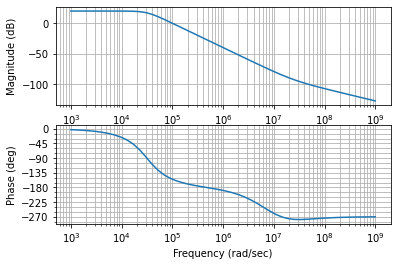

In [ ]:
# Transferencia Entrada - Salida

G_vd = V_in*(RL*(1+s*R_esr*Co))/(RL+s*(Lo+Co*R_esr*RL)+s**2*Lo*Co*(RL+R_esr))
G = G_vd/V_ramp
#bode_G = bode(G)
bode_G_delay = bode(G*delay)
print(G*delay)


In [ ]:
#Diseño del compensador
t = 70*np.pi/90

f_p3 = fs/2
f_z2 = fo*np.sqrt((1-np.sin(t))/(1+np.sin(t)))
f_p2 = fo*np.sqrt((1+np.sin(t))/(1-np.sin(t)))
f_z1 = f_z2/2
print("f_z1 = {0}; f_z2 = {1}; f_p2 = {2}; f_p3 = {3}\nf_esr = {4} ".format(round(f_z1,2), round(f_z2,2),round(f_p2,2),round(f_p3,2),round(f_esr,2)))


#Calculo de los componentes a partir de las frecuencias obtenidas
C_f3 = 2*10**(-9)
R_f3 = 1/(2*np.pi*C_f3*f_p2)
R_f1 = 1/(2*np.pi*C_f3*f_z2) - R_f3
R_c1 = (2*np.pi*fc*Lo*Co*V_ramp)/(V_in*C_f3)
R_f2 = R_f1*V_ref/(V_out-V_ref)

C_c1 = 1/(2*np.pi*R_c1*f_z1)
C_c2 = 1/(2*np.pi*R_c1*f_p3)


print("C_c1 = {0}nF; C_c2 = {1}pF; C_f3 = {2}nF; \nR_c1 = {3}; R_f1 = {4}; R_f2 = {5}; R_f3 = {6} ".format(round(C_c1*10**9,2), round(C_c2*10**12,2), round(C_f3*10**9,2),round(R_c1,2),round(R_f1,2), round(R_f2,2)
,round(R_f3,2)))
print("Se calcularon valores comerciales")



f_z1 = 1173.68; f_z2 = 2347.36; f_p2 = 10795.29; f_p3 = 100000.0
f_esr = 3821247.13 
C_c1 = 12.95nF; C_c2 = 152.04pF; C_f3 = 2.0nF; 
R_c1 = 10467.79; R_f1 = 26529.35; R_f2 = 5823.52; R_f3 = 7371.5 
Se calcularon valores comerciales


In [ ]:
#Calculo de los componentes a partir de las frecuencias obtenidas

#C_c1 = 12.95nF C_c2 = 152.04pF; C_f3 = 2000.0pF; 
#R_c1 = 10467.79; R_f1 = 26529.35; R_f2 = 5823.52; R_f3 = 7371.5

#C_f3 = 2*10**(-9) 
#R_f3 = 1/(2*np.pi*C_f3*f_p2) # = 7371 ~ 7320
#R_f1 = 1/(2*np.pi*C_f3*f_z2) - R_f3 # = 26529 ~ 26580 ~ 26700
#R_c1 = (2*np.pi*fc*Lo*Co*V_ramp)/(V_in*C_f3) # = 10467 ~ 10467 ~ 10500
#R_f2 = R_f1*V_ref/(V_out-V_ref) # = 5823 ~ 5860 ~ 5900

#C_c1 = 1/(2*np.pi*R_c1*f_z1) # = 12.95nF ~ 12.91nF ~ 12nF
#C_c2 = 1/(2*np.pi*R_c1*f_p3) # = 152.04pF ~ 151.58pF ~ 12nF

#C_f3 = 2*10**(-9) 
#R_f3 = 7320
#R_f1 = 26700
#R_c1 = 10500
#R_f2 = 5900

#C_c1 = 12*10**(-9)
#C_c2 = 12*10**(-9)


  1.205e-16 s^2 + 2.666e-12 s + 1.311e-08
-------------------------------------------
1.057e-22 s^3 + 7.435e-17 s^2 + 4.557e-12 s



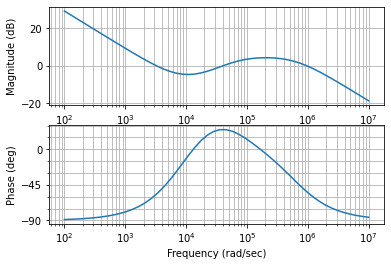

In [ ]:
#Compensador por adelanto de fase
G_c = ((1+s*R_c1*C_c1)*(1+s*(R_f1+R_f3)*C_f3))/(s*R_f1*(C_c1+C_c2)*(1+s*R_f3*C_f3)*(1+s*R_c1*(C_c1*C_c2)/(C_c1+C_c2)))
print (G_c)
bode_Gc = bode(G_c)
#bode_Gc_delay = bode(G_c*delay)

In [ ]:
#Ganancia de lazo
k= (R_f1+R_f2)/R_f2
#k= R_f2/(R_f1+R_f2)


M = series(1/k,G_c,G)

#bode_M = bode(M)
bode_M_delay = bode(M*delay)
print(M*delay)

#gm, pm, wg, wp = margin(M)
#fl = wp/(2*np.pi)
#print("Margen de ganancia: {0} en w = {1}".format(round(gm,3),round(wg,2)))
#print("Margen de fase: {0} en w = {1}".format(round(pm,3),round(wp,2)))

gm, pm, wg, wp = margin(M*delay)
fl = wp/(2*np.pi)
print("Margen de ganancia: {0} en w = {1}".format(round(gm,3),round(wg,2)))
print("Margen de fase: {0} en w = {1}".format(round(pm,3),round(wp,2)))

NameError: ignored